## 1. Data Understanding

🌴 PALM DATASET ANALYSIS 🌴
=== DATASET STRUCTURE ANALYSIS ===
Classes: {0: 'PalmAnom', 1: 'PalmSan'}
Number of classes: 2
TRAIN: 338 images, 338 labels
VALID: 22 images, 22 labels
TEST: 64 images, 64 labels

=== CLASS DISTRIBUTION ANALYSIS ===
TRAIN distribution: {0: np.int64(192), 1: np.int64(244)}
VALID distribution: {0: np.int64(15), 1: np.int64(16)}
TEST distribution: {0: np.int64(31), 1: np.int64(51)}


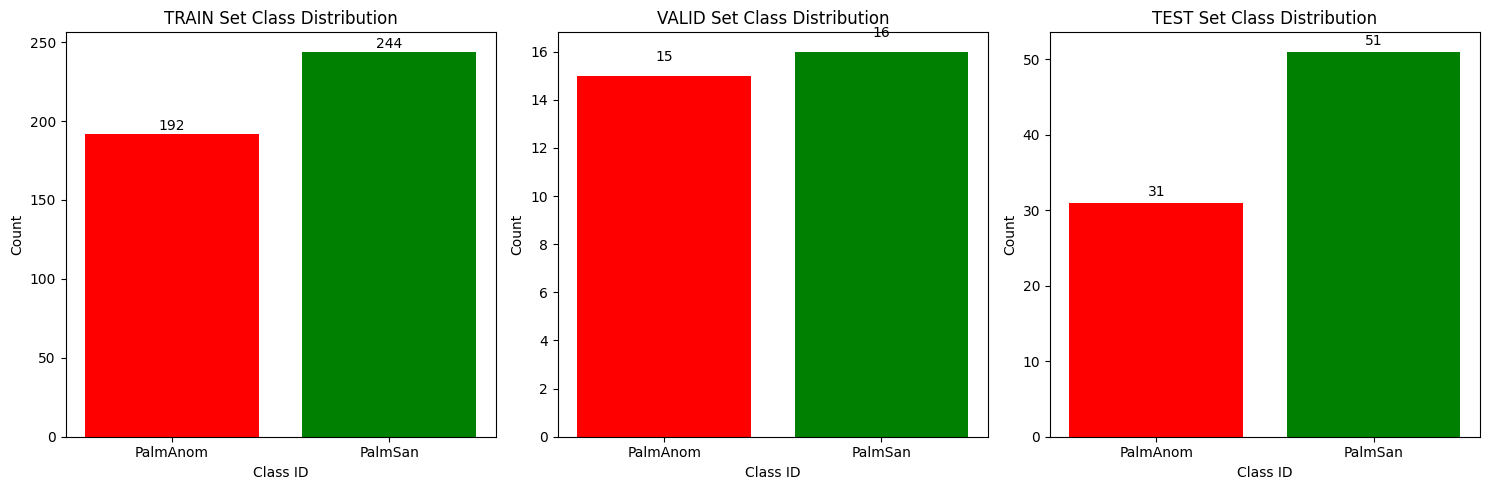

=== BOUNDING BOX STATISTICS ===
Bounding Box Width - Mean: 0.606, Std: 0.135
Bounding Box Height - Mean: 0.765, Std: 0.181
Bounding Box Area - Mean: 0.479, Std: 0.191


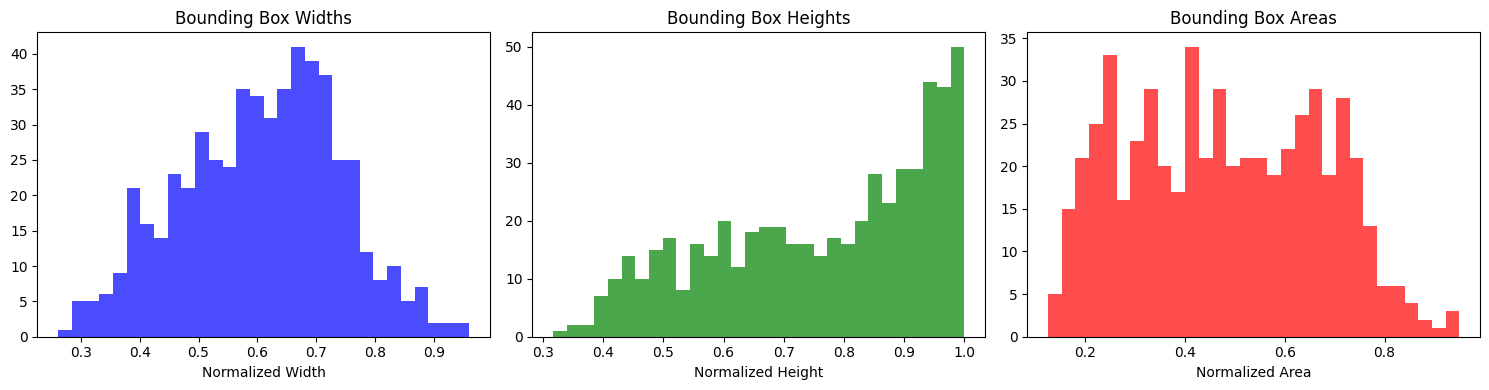

=== CLASS EXAMPLES ===


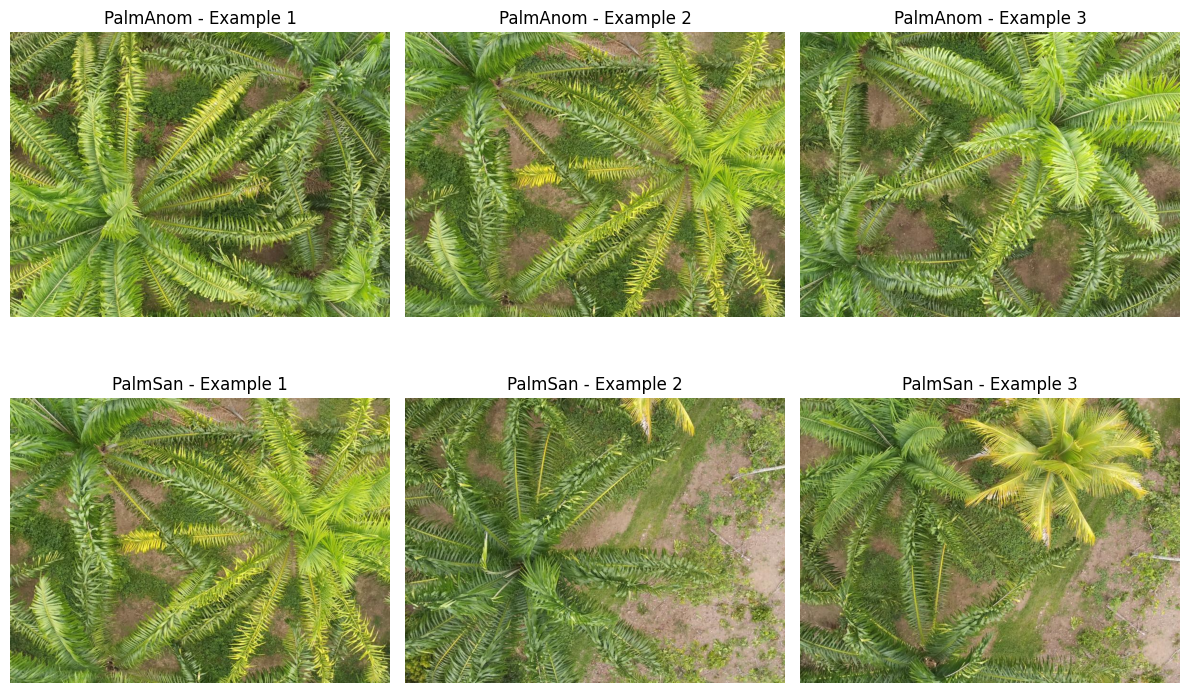

=== RANDOM TRAIN IMAGES WITH ANNOTATIONS ===


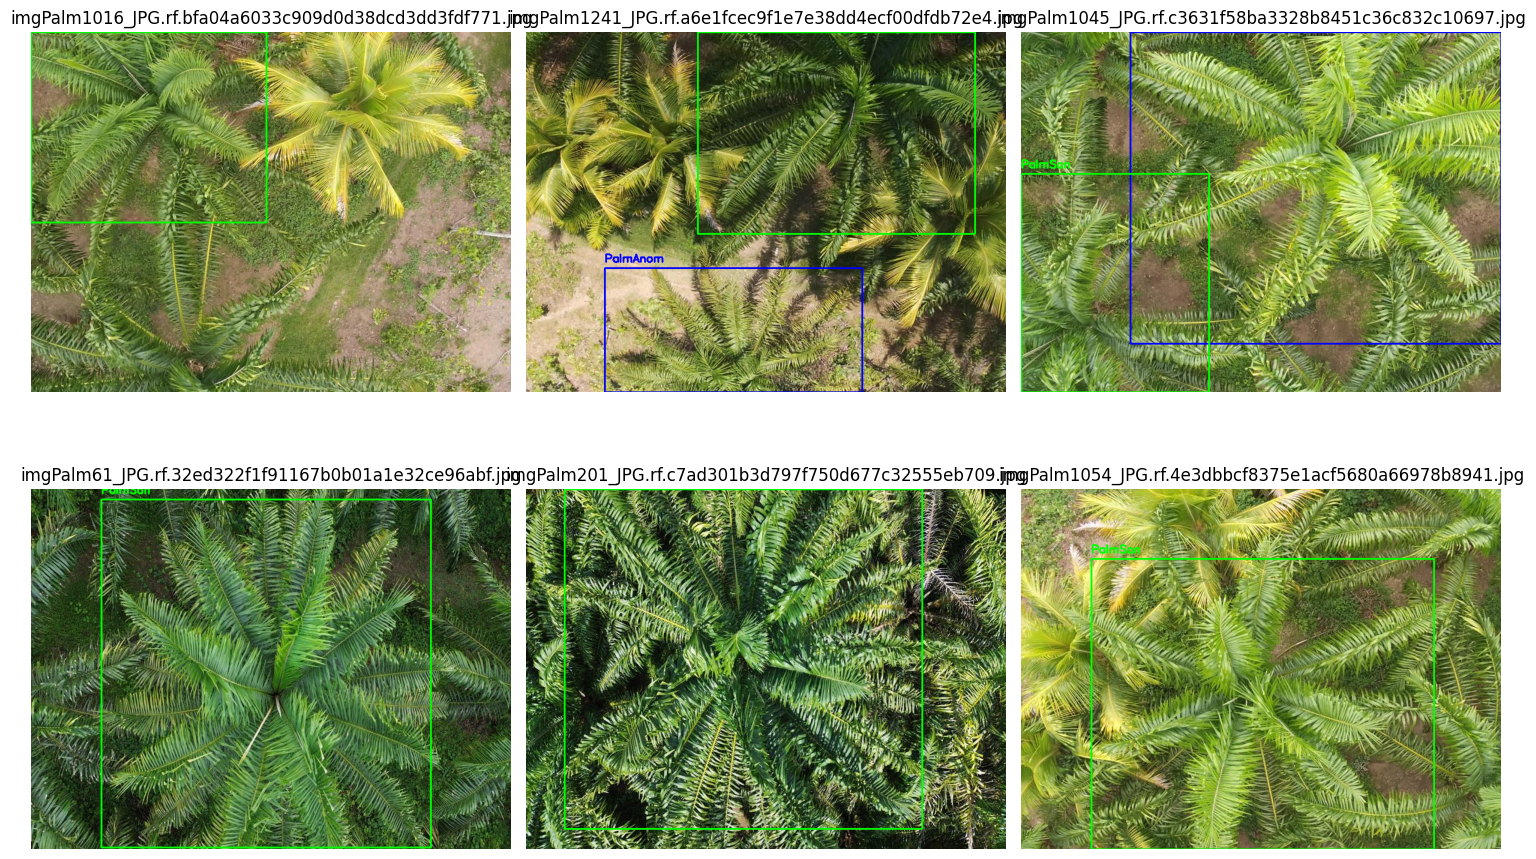


✅ Dataset analysis completed!


In [1]:
# Palm Dataset Data Understanding and Visualization
import os, yaml, random
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from pathlib import Path

# Setup paths for your palm dataset
DATASET_ROOT = Path("datasets/palms_yolo")
YAML_PATH = DATASET_ROOT / "dataset.yaml"

def load_dataset_config():
    """Load dataset configuration from YAML"""
    with open(YAML_PATH, 'r') as f:
        data_yaml = yaml.safe_load(f)
    return data_yaml

def analyze_dataset_structure():
    """Analyze the overall dataset structure"""
    print("=== DATASET STRUCTURE ANALYSIS ===")
    data_yaml = load_dataset_config()
    
    print("Classes:", data_yaml['names'])
    print("Number of classes:", data_yaml['nc'])
    
    # Count files in each split
    for split in ['train', 'valid', 'test']:
        img_dir = DATASET_ROOT / split / 'images'
        lbl_dir = DATASET_ROOT / split / 'labels'
        
        img_count = len(list(img_dir.glob('*.jpg')))
        lbl_count = len(list(lbl_dir.glob('*.txt')))
        
        print(f"{split.upper()}: {img_count} images, {lbl_count} labels")
    print()

def analyze_class_distribution():
    """Analyze class distribution across all splits"""
    print("=== CLASS DISTRIBUTION ANALYSIS ===")
    data_yaml = load_dataset_config()
    class_names = data_yaml['names']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, split in enumerate(['train', 'valid', 'test']):
        labels = []
        label_dir = DATASET_ROOT / split / 'labels'
        
        for label_file in label_dir.glob('*.txt'):
            with open(label_file) as f:
                for line in f:
                    if line.strip():  # Skip empty lines
                        cls = int(line.split()[0])
                        labels.append(cls)
        
        if labels:
            # Count occurrences
            label_series = pd.Series(labels)
            counts = label_series.value_counts().sort_index()
            
            # Plot
            bars = axes[i].bar(counts.index, counts.values, color=['red', 'green'])
            axes[i].set_title(f'{split.upper()} Set Class Distribution')
            axes[i].set_xlabel('Class ID')
            axes[i].set_ylabel('Count')
            axes[i].set_xticks(list(class_names.keys()))
            axes[i].set_xticklabels([class_names[k] for k in class_names.keys()])
            
            # Add count labels on bars
            for bar, count in zip(bars, counts.values):
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                           str(count), ha='center', va='bottom')
            
            print(f"{split.upper()} distribution: {dict(counts)}")
    
    plt.tight_layout()
    plt.show()

def analyze_bbox_statistics():
    """Analyze bounding box statistics"""
    print("=== BOUNDING BOX STATISTICS ===")
    
    all_widths, all_heights, all_areas = [], [], []
    
    for split in ['train', 'valid', 'test']:
        label_dir = DATASET_ROOT / split / 'labels'
        
        for label_file in label_dir.glob('*.txt'):
            with open(label_file) as f:
                for line in f:
                    if line.strip():
                        parts = line.split()
                        if len(parts) >= 5:
                            _, x, y, w, h = map(float, parts[:5])
                            all_widths.append(w)
                            all_heights.append(h)
                            all_areas.append(w * h)
    
    # Statistics
    print(f"Bounding Box Width - Mean: {np.mean(all_widths):.3f}, Std: {np.std(all_widths):.3f}")
    print(f"Bounding Box Height - Mean: {np.mean(all_heights):.3f}, Std: {np.std(all_heights):.3f}")
    print(f"Bounding Box Area - Mean: {np.mean(all_areas):.3f}, Std: {np.std(all_areas):.3f}")
    
    # Visualize distributions
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(all_widths, bins=30, alpha=0.7, color='blue')
    axes[0].set_title('Bounding Box Widths')
    axes[0].set_xlabel('Normalized Width')
    
    axes[1].hist(all_heights, bins=30, alpha=0.7, color='green')
    axes[1].set_title('Bounding Box Heights')
    axes[1].set_xlabel('Normalized Height')
    
    axes[2].hist(all_areas, bins=30, alpha=0.7, color='red')
    axes[2].set_title('Bounding Box Areas')
    axes[2].set_xlabel('Normalized Area')
    
    plt.tight_layout()
    plt.show()

def show_random_images(split='train', n=6):
    """Show random images with bounding boxes"""
    print(f"=== RANDOM {split.upper()} IMAGES WITH ANNOTATIONS ===")
    
    data_yaml = load_dataset_config()
    class_names = data_yaml['names']
    
    img_dir = DATASET_ROOT / split / 'images'
    img_files = list(img_dir.glob('*.jpg'))
    
    if len(img_files) == 0:
        print(f"No images found in {img_dir}")
        return
    
    # Select random images
    selected_imgs = random.sample(img_files, min(n, len(img_files)))
    
    # Calculate grid size
    cols = 3
    rows = (len(selected_imgs) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[ax] for ax in axes]
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # BGR colors
    
    for idx, img_path in enumerate(selected_imgs):
        row, col = idx // cols, idx % cols
        
        # Load image
        img = cv2.imread(str(img_path))
        if img is None:
            continue
            
        h, w, _ = img.shape
        
        # Load corresponding label
        label_path = str(img_path).replace('images', 'labels').replace('.jpg', '.txt')
        
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line_num, line in enumerate(f):
                    if line.strip():
                        parts = line.split()
                        if len(parts) >= 5:
                            cls, x, y, bw, bh = map(float, parts[:5])
                            
                            # Convert normalized coords to pixel coords
                            x1 = int((x - bw/2) * w)
                            y1 = int((y - bh/2) * h)
                            x2 = int((x + bw/2) * w)
                            y2 = int((y + bh/2) * h)
                            
                            # Draw bounding box
                            color = colors[int(cls) % len(colors)]
                            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                            
                            # Draw class label
                            class_name = class_names.get(int(cls), f"Class {int(cls)}")
                            cv2.putText(img, class_name, (x1, y1-10), 
                                      cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Convert BGR to RGB for matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Display
        axes[row][col].imshow(img_rgb)
        axes[row][col].set_title(f"{img_path.name}")
        axes[row][col].axis('off')
    
    # Hide unused subplots
    for idx in range(len(selected_imgs), rows * cols):
        row, col = idx // cols, idx % cols
        axes[row][col].axis('off')
    
    plt.tight_layout()
    plt.show()

def show_class_examples():
    """Show examples of each class"""
    print("=== CLASS EXAMPLES ===")
    
    data_yaml = load_dataset_config()
    class_names = data_yaml['names']
    
    # Find examples of each class
    class_examples = {cls_id: [] for cls_id in class_names.keys()}
    
    for split in ['train', 'valid', 'test']:
        label_dir = DATASET_ROOT / split / 'labels'
        
        for label_file in label_dir.glob('*.txt'):
            with open(label_file) as f:
                for line in f:
                    if line.strip():
                        cls = int(line.split()[0])
                        img_path = str(label_file).replace('labels', 'images').replace('.txt', '.jpg')
                        if os.path.exists(img_path) and len(class_examples[cls]) < 3:
                            class_examples[cls].append(img_path)
    
    # Display examples
    fig, axes = plt.subplots(len(class_names), 3, figsize=(12, 4*len(class_names)))
    if len(class_names) == 1:
        axes = [axes]
    
    for cls_id, class_name in class_names.items():
        for col, img_path in enumerate(class_examples[cls_id][:3]):
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[cls_id][col].imshow(img_rgb)
            axes[cls_id][col].set_title(f"{class_name} - Example {col+1}")
            axes[cls_id][col].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("🌴 PALM DATASET ANALYSIS 🌴")
    print("=" * 50)
    
    # Run all analyses
    analyze_dataset_structure()
    analyze_class_distribution()
    analyze_bbox_statistics()
    show_class_examples()
    show_random_images('train', 6)
    
    print("\n✅ Dataset analysis completed!")